In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import recall_score, precision_recall_curve, auc
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2, l1_l2
from keras.optimizers import Adam, SGD

tf.random.set_seed(42)
np.random.seed(42)

# Set global font to Times New Roman and DPI to 600
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 400

In [2]:
# PU loss function

def pu_loss(prior):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)

        # Positive term: mean over ACTUAL positives only
        positive_mask = tf.cast(tf.equal(y_true, 1), tf.float32)
        n_positive = tf.reduce_sum(positive_mask)+ 1e-7  # Count actual positives and avoid division by zero
        positive_term = -tf.reduce_sum(positive_mask * tf.math.log(y_pred + 1e-7)) / n_positive

        # Unlabeled term
        unlabeled_mask = tf.cast(tf.equal(y_true, 0), tf.float32)
        n_unlabeled =  tf.reduce_sum(unlabeled_mask) + 1e-7  # Count unlabeled samples and avoid division by zero
        unlabeled_term_1 = -tf.reduce_sum(unlabeled_mask * tf.math.log(1 - y_pred + 1e-7)) / n_unlabeled
        unlabeled_term_2 = -tf.reduce_sum(positive_mask * tf.math.log(1 - y_pred + 1e-7)) / n_positive

        pu_loss = prior * positive_term +  tf.maximum((unlabeled_term_1 - prior * unlabeled_term_2),0)
        return pu_loss
    return loss

In [3]:
tf.__version__

'2.19.0'

In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# 1. Load the data
file_path = "/content/drive/MyDrive/MuRG/Data/data.xlsx"  # Change this to your file path
data = pd.read_excel(file_path)
data = data.dropna(axis=1)
#data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Drug_Names,SMILES,Label,Source,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Abemaciclib,CCN1CCN(CC1)CC2=CN=C(C=C2)NC3=NC=C(C(=N3)C4=CC...,0,CHEMBL,14.938285,14.938285,0.009538,-0.636008,0.380688,15.108108,...,0,0,0,0,0,0,0,0,0,0
1,Acalabrutinib,CC#CC(=O)N1CCC[C@H]1C2=NC(=C3N2C=CN=C3N)C4=CC=...,0,CHEMBL,12.610319,12.610319,0.209630,-0.260221,0.446551,15.000000,...,0,0,0,0,0,0,0,0,0,0
2,Acetazolamide,CC(=O)NC1=NN=C(S1)S(=O)(=O)N,1,DrugBank,10.704978,10.704978,0.107894,-3.824175,0.631859,11.230769,...,0,1,0,0,0,0,0,0,0,0
3,Acetophenone,CC(=O)C1=CC=CC=C1,1,DrugBank,10.645370,10.645370,0.120926,0.120926,0.517047,9.000000,...,0,0,0,0,0,0,0,0,0,0
4,Acitretin,CC1=CC(=C(C(=C1/C=C/C(=C/C=C/C(=C/C(=O)O)/C)/C...,1,DrugBank,10.557328,10.557328,0.701850,-0.931877,0.579454,13.083333,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X = data.drop(['Drug_Names', 'SMILES', 'Label', 'Source'], axis=1)  # Assuming these are non-descriptor columns
y = data['Label']
print("Number of Drugs", X.shape[0])
print("Number of Features", X.shape[1])
# Check for missing values
print("Missing values in features:", X.isnull().sum().sum())

Number of Drugs 365
Number of Features 205
Missing values in features: 0


In [12]:
# Split data into training and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify = y_temp)

print("X_train size", X_train.shape, "y_train size", y_train.shape)
print("X_test size", X_test.shape, "\ty_test size", y_test.shape)
print("X_val size", X_val.shape, "\ty_val size", y_val.shape)

X_train size (255, 205) y_train size (255,)
X_test size (55, 205) 	y_test size (55,)
X_val size (55, 205) 	y_val size (55,)


In [13]:
#$$$$$$$$$$$$$------------------------ Scaling the features --------------------------------$$$$$$$$$$#
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [14]:

model = Sequential([
                    Input(shape = (X_train.shape[1],) ),
                    Dense(64, activation='relu',kernel_regularizer =l2(0.01)),
                    Dropout(0.5),
                    Dense(16, activation='relu',kernel_regularizer =l2(0.01)),
                    Dropout(0.5),
                    Dense(8, activation='relu',kernel_regularizer =l2(0.01)),
                    Dropout(0.5),
                    Dense(1, activation='sigmoid')
                 ])
adam = Adam(learning_rate = 0.001)
sgd = SGD(learning_rate = 0.0001, momentum=0.1)
# Compile the model
model.compile(optimizer=adam, loss=pu_loss(prior=0.5), metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        13,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,369 (56.13 KB)

 Trainable params: 14,369 (56.13 KB)

 Non-trainable params: 0 (0.00 B)

None


In [15]:
# 4. Train the model
with tf.device('/GPU:0'):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=500, batch_size=8, verbose=1)

Epoch 1/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - accuracy: 0.4879 - loss: 2.1493 - val_accuracy: 0.5091 - val_loss: 1.9164
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5935 - loss: 1.9131 - val_accuracy: 0.5455 - val_loss: 1.8341
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5504 - loss: 1.8460 - val_accuracy: 0.6182 - val_loss: 1.7542
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5789 - loss: 1.7328 - val_accuracy: 0.5455 - val_loss: 1.7478
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5449 - loss: 1.6848 - val_accuracy: 0.5455 - val_loss: 1.7140
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5384 - loss: 1.7379 - val_accuracy: 0.5273 - val_loss: 1.6646
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5878 - loss: 1.6750 - val_accuracy: 0.5636 - val_loss: 1.5897
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6218 - loss: 1.5909 - val_accuracy: 0.563

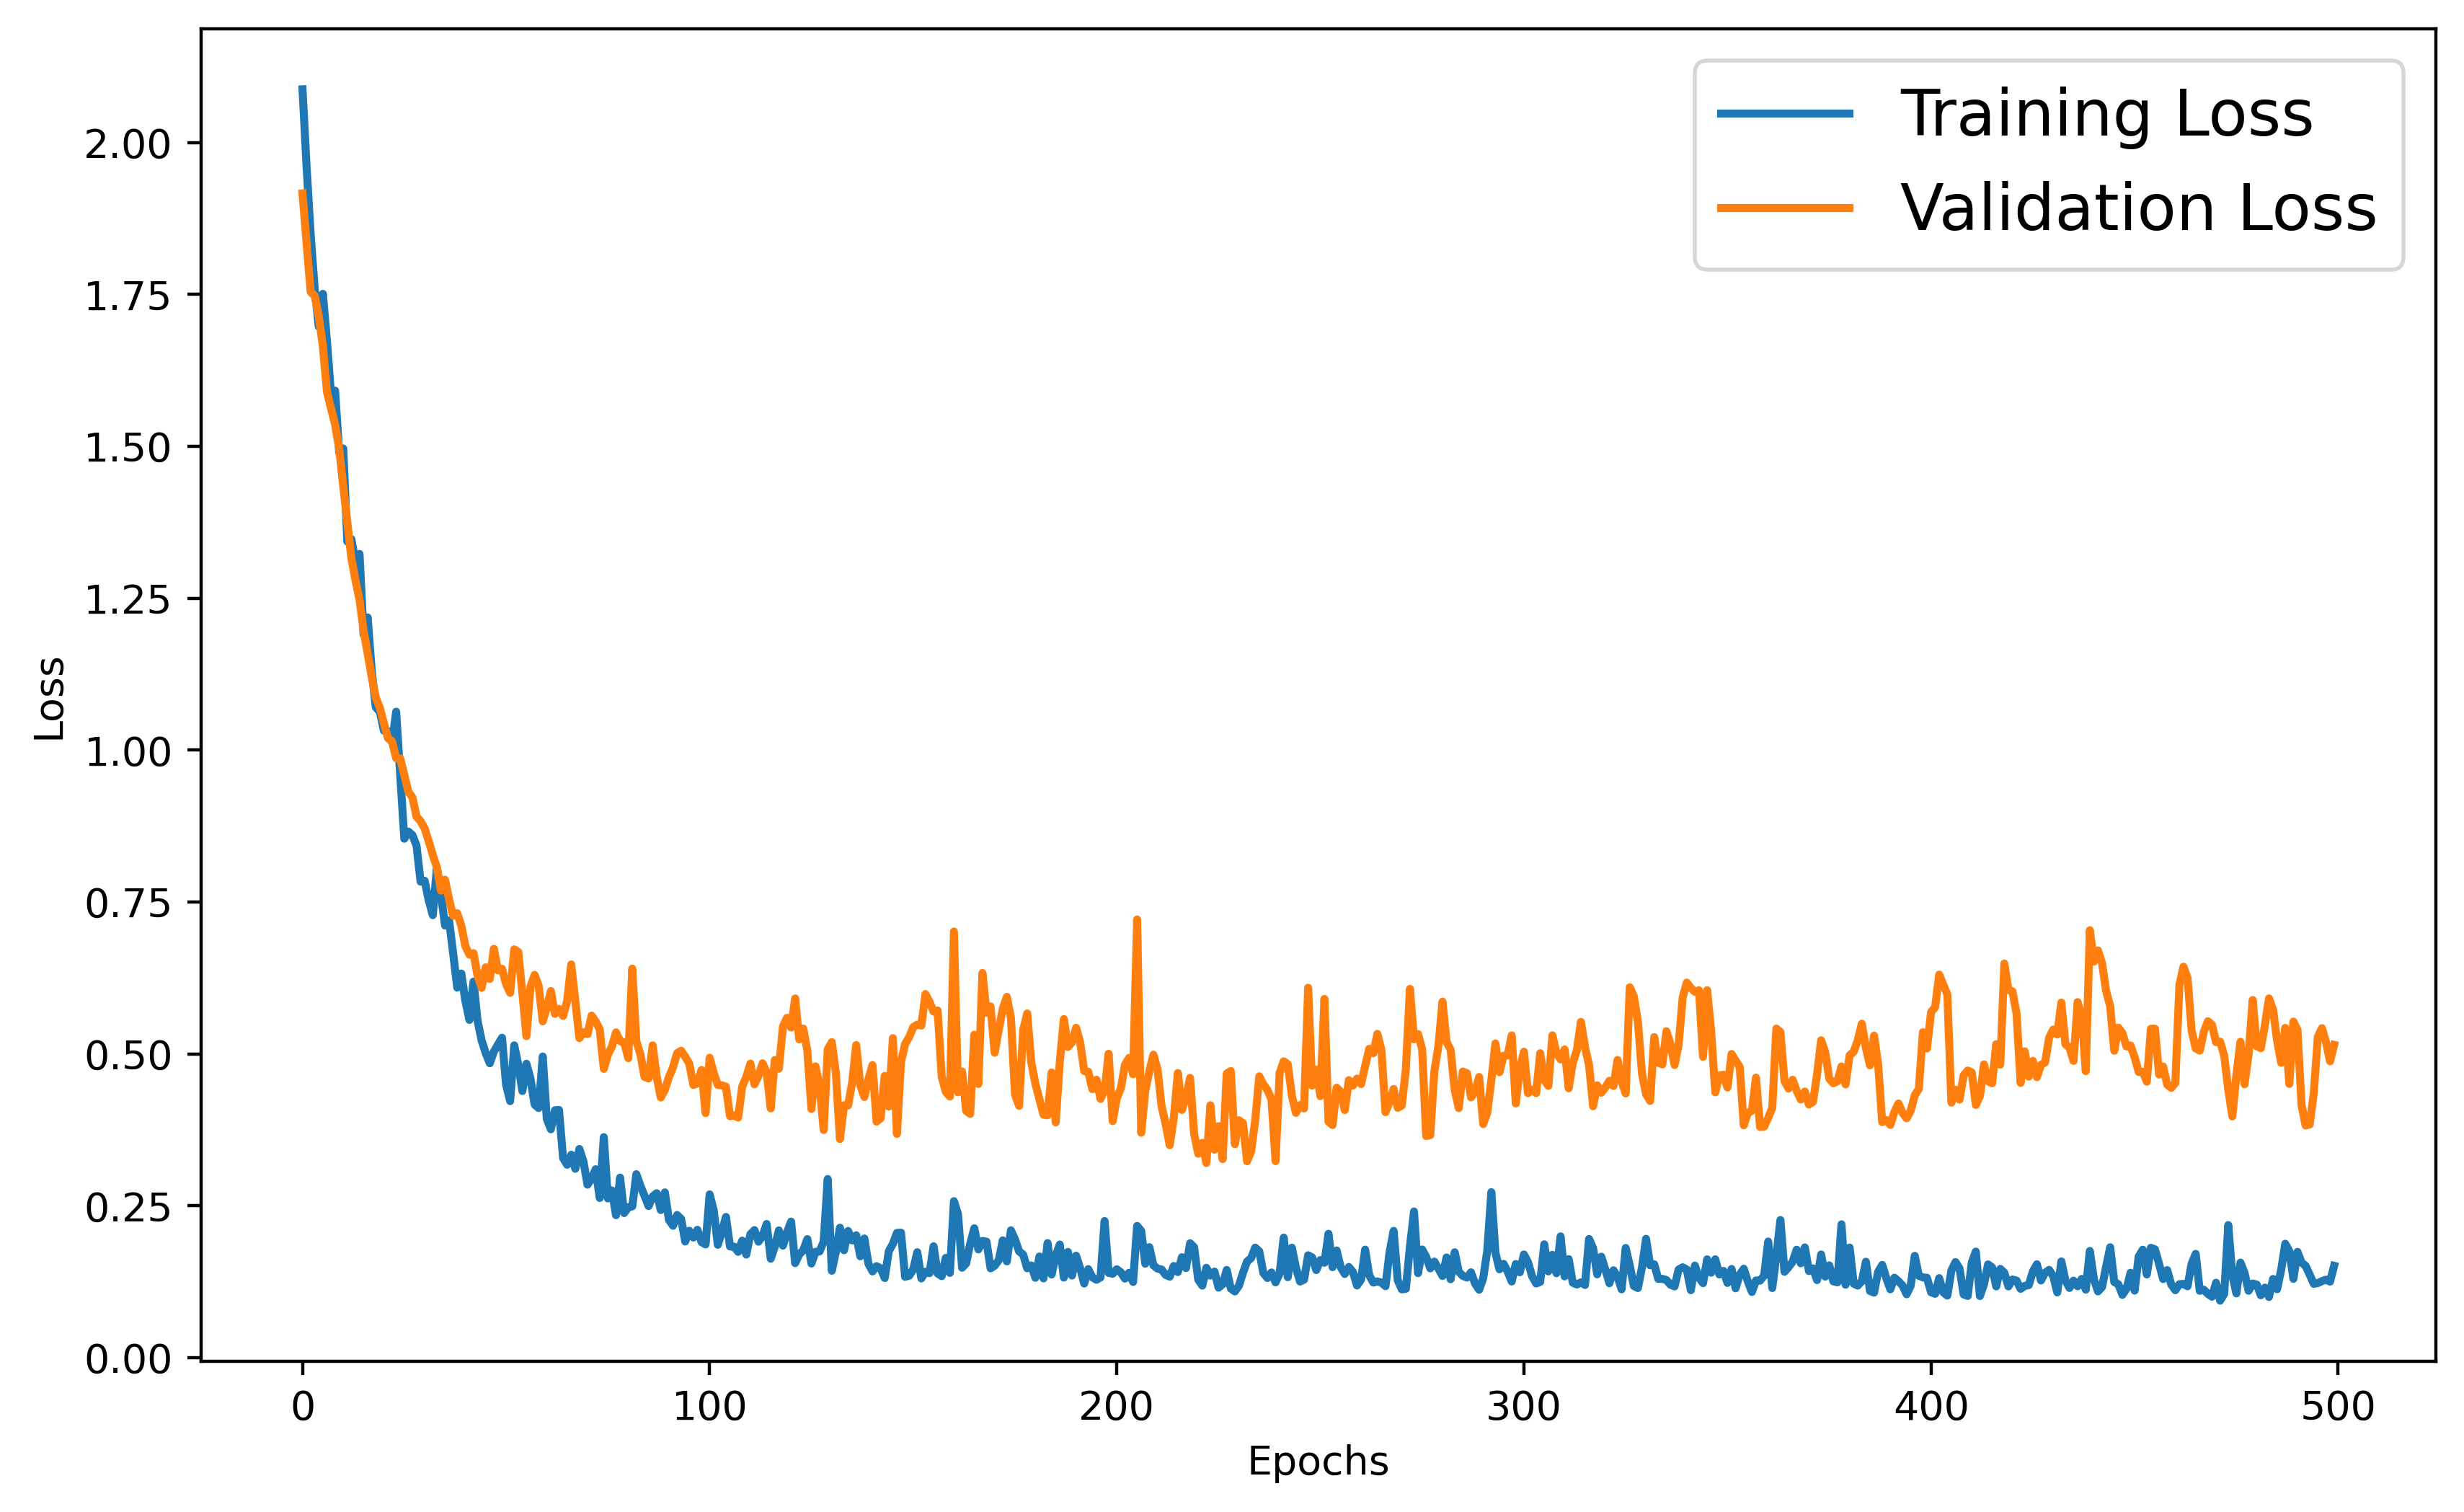

In [16]:
#################################### LOSS CURVE ##################################

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss',lw=2)
plt.plot(history.history['val_loss'], label='Validation Loss',lw=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=16)
plt.savefig("Loss_Curve_PU.png")
plt.show()

# Create a DataFrame from the history dictionary
history_df = pd.DataFrame({
    'Epoch': range(1, len(history.history['loss']) + 1),
    'Training Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss']
})

# Save to Excel file
history_df.to_excel('training_history_PU_NN.xlsx', index=False)

In [17]:
#################################### PREDICTION ##################################

y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [18]:
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Convert predictions to numpy arrays if they aren't already
y_train_pred = np.squeeze(y_train_pred)
y_val_pred = np.squeeze(y_val_pred)
y_test_pred = np.squeeze(y_test_pred)

# Compute metrics for each set
def compute_pu_metrics(y_true, y_pred_proba, set_name=""):
    # Recall (True Positive Rate)
    recall = recall_score(y_true, (y_pred_proba > 0.5).astype(int))

    # Precision Upper Bound
    predicted_positives = (y_pred_proba > 0.5).sum()
    true_positives = ((y_pred_proba > 0.5) & (y_true == 1)).sum()
    false_positives = ((y_pred_proba > 0.5) & (y_true == 0)).sum() ################### identified hidden positives
    precision_upper = true_positives / predicted_positives if predicted_positives > 0 else 0

    # AUC-PR
    precision, recall_pr, _ = precision_recall_curve(y_true, y_pred_proba)
    auc_pr = auc(recall_pr, precision)

    print(f"\n{set_name} PU Metrics:")
    print(f"1. Recall (TPR): {recall:.4f}")
    print(f"2. Precision Upper Bound: {precision_upper:.4f}")
    print(f"3. AUC-PR: {auc_pr:.4f}")

    return recall, precision_upper, auc_pr

# Calculate for all sets
print("="*50)
train_recall, train_prec_upper, train_auc_pr = compute_pu_metrics(y_train, y_train_pred, "Training")
val_recall, val_prec_upper, val_auc_pr = compute_pu_metrics(y_val, y_val_pred, "Validation")
test_recall, test_prec_upper, test_auc_pr = compute_pu_metrics(y_test, y_test_pred, "Test")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

Training PU Metrics:
1. Recall (TPR): 1.0000
2. Precision Upper Bound: 0.6778
3. AUC-PR: 0.9872

Validation PU Metrics:
1. Recall (TPR): 0.9259
2. Precision Upper Bound: 0.5682
3. AUC-PR: 0.8658

Test PU Metrics:
1. Recall (TPR): 0.9615
2. Precision Upper Bound: 0.6098
3. AUC-PR: 0.8278


In [ ]:
model.save('drug_classification_model_with_PU_Loss.h5')
#Save the scaler for future use

joblib.dump(scaler, 'scaler.save')

['scaler.save']